In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

In [3]:
# Load Data
df = pd.read_excel('/content/data_bersih_twitter.xlsx')
df.columns = ['tweet','label']
df.head()

tweet  label
0  posisi kunci aman mudah pengaruh pinjam tipu o...      1
1  brigadir jenderal wisnu hermawan tahu polisi p...      2
2  tolong ada scam di akun instagram scam kedok p...      0
3                                 pinjam tipu online      0
4  kemudi dalam posisi kunci yang aman mudah peng...      1

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


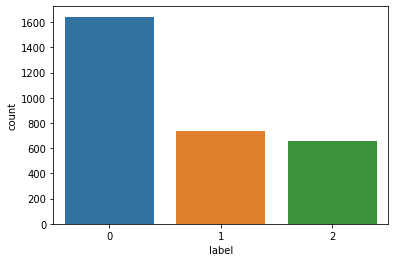

In [4]:
# inspect sentiment
sns.countplot(df['label'])

In [5]:
# text length
df['text_length'] = df['tweet'].apply(len)
df[['label','text_length','tweet']].head()

label  text_length                                              tweet
0      1           51  posisi kunci aman mudah pengaruh pinjam tipu o...
1      2          108  brigadir jenderal wisnu hermawan tahu polisi p...
2      0          109  tolong ada scam di akun instagram scam kedok p...
3      0           18                                 pinjam tipu online
4      1           78  kemudi dalam posisi kunci yang aman mudah peng...

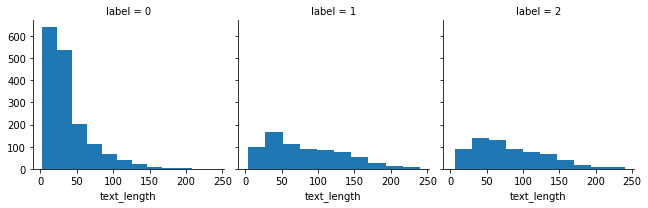

In [6]:
g = sns.FacetGrid(df,col='label')
g.map(plt.hist,'text_length')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


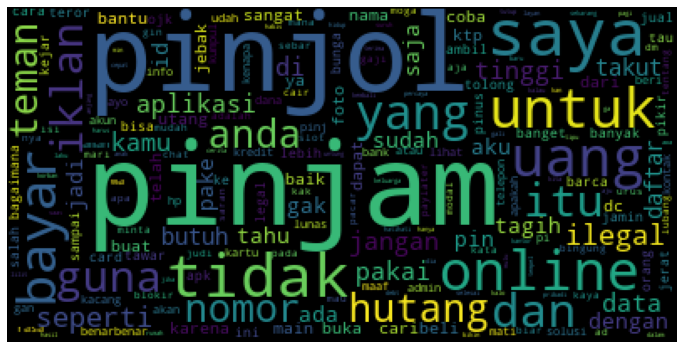

In [9]:
 import nltk
 nltk.download('stopwords')

from nltk.corpus import stopwords
from wordcloud import WordCloud
import re

def clean_text(s):
    s = re.sub(r'http\S+', '', s)
    s = re.sub('(RT|via)((?:\\b\\W*@\\w+)+)', ' ', s)
    s = re.sub(r'@\S+', '', s)
    s = re.sub('&amp', ' ', s)
    return s
df['clean_tweet'] = df['tweet'].apply(clean_text)

text = df['clean_tweet'].to_string().lower()    
wordcloud = WordCloud(
    collocations=False,
    relative_scaling=0.5,
    stopwords=set(stopwords.words('english'))).generate(text)

plt.figure(figsize=(12,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [10]:
seed = 101 # fix random seed for reproducibility
np.random.seed(seed)

In [8]:
# Encode Categorical Variable
X = df['clean_tweet']
y = pd.get_dummies(df['label']).values
num_classes = df['label'].nunique()

In [37]:
# Split Train Test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.1,
                                                    stratify=y,
                                                    random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2736,) (305,) (2736, 3) (305, 3)


In [38]:
# Tokenize Text
from keras.preprocessing.text import Tokenizer
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

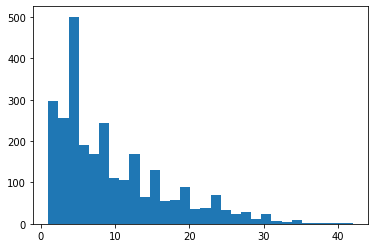

In [39]:
totalNumWords = [len(one_comment) for one_comment in X_train]
plt.hist(totalNumWords,bins = 30)
plt.show()

In [40]:
from keras.preprocessing import sequence
max_words = 30
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
print(X_train.shape,X_test.shape)

(2736, 30) (305, 30)


In [41]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense,Embedding,Conv1D,MaxPooling1D,LSTM
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [53]:
def get_model(max_features, embed_dim):
    np.random.seed(seed)
    K.clear_session()
    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1]))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))    
    model.add(LSTM(150, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

In [54]:
def model_train(model):
    # train the model
    model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                          epochs=epochs, batch_size=batch_size, verbose=2)
    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('Akurasi')
    plt.xlabel('Epoch')
    plt.legend(['Data Latih', 'Data Testing'], loc='upper left')
    plt.show()
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Data Latih', 'Data Testing'], loc='upper left')
    plt.show()

In [55]:
def model_evaluate(): 
    # predict class with test set
    y_pred_test =  np.argmax(model.predict(X_test), axis=1)
    print('Accuracy:\t{:0.1f}%'.format(accuracy_score(np.argmax(y_test,axis=1),y_pred_test)*100))
    
    #classification report
    print('\n')
    print(classification_report(np.argmax(y_test,axis=1), y_pred_test))

    #confusion matrix
    confmat = confusion_matrix(np.argmax(y_test,axis=1), y_pred_test)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

In [56]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from tensorflow.keras.optimizers import Adam 
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.activations import relu
import pandas as pd
import sklearn
import keras

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# train the model
max_features = 20000
embed_dim = 1000
batch_size = 16
epochs = 20
model = get_model(max_features, embed_dim)
model_train(model)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 1000)          20000000  
                                                                 
 conv1d (Conv1D)             (None, 30, 32)            96032     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 15, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 32)            3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 7, 32)            0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 150)               1

In [ ]:
# evaluate model with test set
model_evaluate()